# Libs

In [1]:

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np

import os
import re
import sys

import seaborn as sns

import pickle
 
from collections import defaultdict
    
sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")
sys.path.append("/home/dhw3172/projects/barycenterAgePyramid/Python")

from WassAge import *

from pathlib import Path

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Params

In [2]:
DATA_PATH = Path("." ) / ".." / ".." / "Data" 
os.listdir(DATA_PATH)

['Numpy',
 'shpMtlDAAgePyramid',
 'QuebecNeighbourhoods',
 '.ipynb_checkpoints',
 'MontrealNeighbourhoods',
 'shpQcDAAgePyramid',
 'Extremal']

In [3]:
np.random.seed(1)

In [4]:
useApproxWass= False
approxStr = "Exact" if useApproxWass else "Approximate"

In [5]:
city="Montreal"
#city="Quebec City"

# Data IO

## Load back the city-wide wass barycenter + DA shp

In [6]:
def readBackWass(city):
    dfGeoClean = normalizeCleanDfGeo( readDAShp(city=city) )
    dfGeoCleanAge = dfGeoClean[LIST_AGE_COLS]
    
    subsetRows= dfGeoClean.shape[0] if city == "Quebec City" else 900
    with open(Path(".") /".." / ".." / "Data" / "Numpy" / f"cityWideDAWassBarycenter_{subsetRows}_{city}.pickle", "rb") as f:
        bary_wass=pickle.load( f )
        
    return bary_wass, dfGeoCleanAge, dfGeoClean

In [7]:
dictWass=defaultdict(str)
dictGeoClean=defaultdict(str)
dictGeo=defaultdict(str)

for n in ["Quebec City" , "Montreal"]:
    w,dclean,d=readBackWass(n)
    dictWass[n] = w / np.sum(w)          #might be small scaling errors => make sure sum is really 1
    dictGeoClean[n] = dclean
    dictGeo[n] = d

Reading neibourhoods from Quebec City
Reading neibourhoods from Montreal


# Evaluate departure from reference young distribution with all weight at 0

## Reference young distribution: mass of 1 at 0

In [8]:
youngRefDist = np.zeros( shape=(len(getAgeRepresentativeArray()),))
youngRefDist[0]=1
youngRefDist.shape
np.sum(youngRefDist)

1.0

In [9]:
youngRef = np.ones((1,1))
youngRef

array([[1.]])

## Distance matrix from age bin centroids

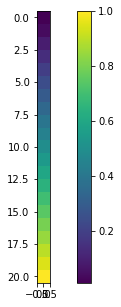

In [10]:
plt.figure(figsize=(10,5))
distMat = distance_matrix(getAgeRepresentativeArray(),youngRef)
distMat= distMat / np.max( distMat)
plt.imshow(distMat)
plt.colorbar()

## Compute EMD

In [11]:
dictOptTransport=defaultdict(str)
dictDist=defaultdict(str)

for n in ["Quebec City" , "Montreal"]:
    optT =ot.lp.emd(dictWass[n], youngRefDist  ,distMat)
    
    dictOptTransport[n] = optT
    dictDist[n] = np.sum( optT[:] * distMat[:])

In [12]:
#Build the labels

In [13]:
np.linspace(0,21,num=int(21/2))
listIndex=[i for i in range(21) if i % int(21/7) == 0]
listIndex
listAgeSubset = np.array(LIST_AGE_COLS)[listIndex]
listAgeSubset, len(listAgeSubset)

(array(['0_4', '15_19', '30_34', '45_49', '60_64', '75_79', '90_94'],
       dtype='<U5'), 7)

In [14]:
listIndex=[ int( np.quantile(range(len(LIST_AGE_COLS)), i/9)) for i in range(10) ]
listAgeSubset = np.array(LIST_AGE_COLS)[listIndex]
listAgeSubset, len(listAgeSubset), len(listIndex)

(array(['0_4', '10_14', '20_24', '30_34', '40_44', '55_59', '65_69',
        '75_79', '85_89', '100_+'], dtype='<U5'), 10, 10)

## Visualize optimal transport 

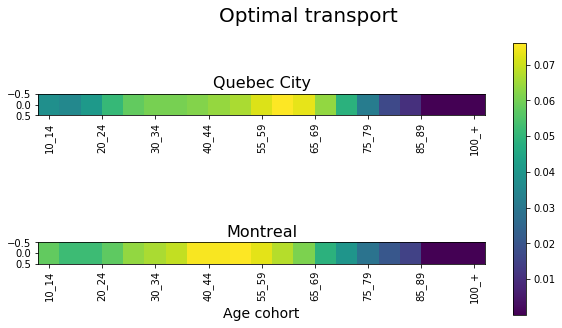

In [15]:
fig=plt.figure(figsize=(10,5))
listAxes=[]
for k,n in enumerate(["Quebec City" , "Montreal"]):
    
    ax=plt.subplot(2,1,k+1) 
    listAxes.append(ax)
    plt.imshow( dictOptTransport[n].T )
    ax.set_title(f"{n}", fontsize=16)
    plt.xticks(rotation=90)
    #idxToSelect = np.array( ax.get_xticklabels() ) == np.arange(len(LIST_AGE_COLS))
    #print( np.array( ax.get_xticks()) ) 
    ax.set_xticklabels(labels=listAgeSubset)
    if n =="Montreal":
        ax.set_xlabel("Age cohort", fontsize=14)
 
                 
fig.suptitle("Optimal transport",fontsize=20,ha="center")
plt.colorbar(ax=listAxes)

#plt.tight_layout(h_pad=2)

fig.savefig( Path(DATA_PATH) /".."/ "Figures" / "ReferenceDistributions"  / f"wassOptTransFromYoungDist.png")

## Compare cost


In [16]:
dfDist=pd.DataFrame.from_dict(dictDist, columns=['distance'] , orient='index').reset_index()
dfDist.rename(columns={"index":"city"},inplace=True)
dfDist

city  distance
0  Quebec City  0.402835
1     Montreal  0.372845

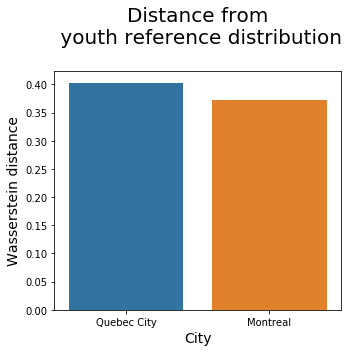

In [17]:
fig = plt.figure(figsize=(5,5))

ax = sns.barplot(x="city", y="distance"  ,data=dfDist)
ax.set_title("Distance from\n youth reference distribution\n", fontsize=20)
ax.set_xlabel('City',fontsize=14);
ax.set_ylabel('Wasserstein distance',fontsize=14);


plt.tight_layout(rect=[0, 0, 1, 1])

fig.savefig( Path(DATA_PATH) /".."/ "Figures" / "ReferenceDistributions"  / f"wassDistFromYoungDist.png")

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 1080x1080 with 0 Axes>

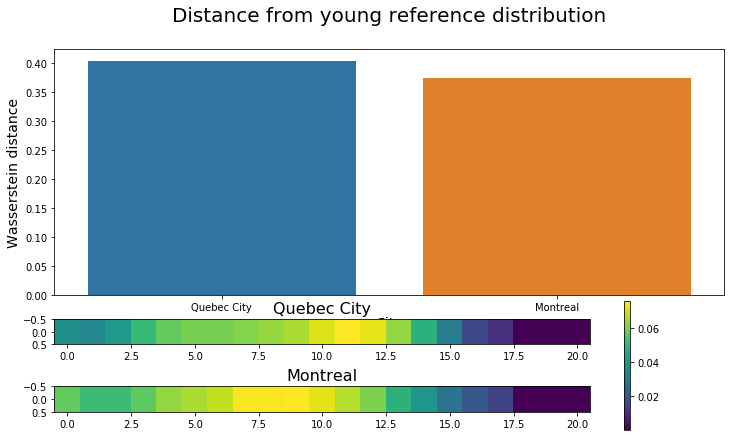

In [18]:
import matplotlib
fig=plt.figure(figsize=(15,15))
ax = [None]*(2 + 1)

fig = plt.figure(figsize=(12,7))
gs = matplotlib.gridspec.GridSpec(nrows=3, 
                       ncols=1, 
                       figure=fig, 
                       #width_ratios= [3, 1],
                       height_ratios= [4,1,1],
                       wspace=0.2, hspace=0.05
                      )

ax[0] = fig.add_subplot(gs[0, 0])
sns.barplot(x="city", y="distance"  ,data=dfDist, ax=ax[0])
ax[0].set_title("Distance from young reference distribution\n", fontsize=20)
ax[0].set_xlabel('City',fontsize=14);
ax[0].set_ylabel('Wasserstein distance',fontsize=14);

ax[1] = fig.add_subplot(gs[  1 ,0 ])
listAxes.append(ax[1])
plt.imshow( dictOptTransport["Quebec City" ].T  )
ax[1].set_title("Quebec City", fontsize=16)

ax[2] = fig.add_subplot(gs[  2 ,0 ])
listAxes.append(ax[1])
plt.imshow( dictOptTransport["Montreal" ].T  )
ax[2].set_title("Montreal", fontsize=16)

plt.colorbar(ax=[ax[1],ax[2]])

plt.tight_layout(h_pad=2)